# Compute seasonal net outgassing of O2 and APO

Start with [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like [util.py](util.py).

In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import os

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import util

import intake

## Connect to catalog

This notebook uses an [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to describe file locations. This is the basis of [intake-esm](https://intake-esm.readthedocs.io/en/latest/), though here we are not using `intake-esm` directly.

In [64]:
cat = intake.open_esm_datastore(util.catalog_json)
cat

,unique
activity_id,17
institution_id,34
source_id,74
experiment_id,127
member_id,399
table_id,35
variable_id,1064
grid_label,12
dcpp_init_year,59
version,500


In [65]:
%%time
df = pd.read_csv(util.catalog_csv)
df

CPU times: user 5.7 s, sys: 2.34 s, total: 8.04 s
Wall time: 8.21 s


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r3i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
...,...,...,...,...,...,...,...,...,...,...,...,...
1850252,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,209901010600-210001010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850253,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,6hrLev,va,gn,NaN,v20200602,210001010600-210101010000,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850254,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20150101-20491230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
1850255,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Oday,tos,gn,NaN,v20190726,20500101-20991230,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...


## Specify a subset of models

In [66]:
models = [
    'CanESM5', ## gives non-monotonic coord error for fgco2 in combine_by_coords below 
    'CanESM5-CanOE', ## no fgo2 (somehow PM was plotting)
    'CNRM-ESM2-1', 
    'ACCESS-ESM1-5',  
    'MPI-ESM-1-2-HAM', 
    'IPSL-CM6A-LR',
    'MPI-M.MPI-ESM1-2-HR', # not plotting bc no areacello
    'MPI-ESM1-2-LR',  
    'NorCPM1', # not plotting bc no areacello
    'NorESM2-LM', 
    'UKESM1-0-LL',
    'MIROC-ES2L', 
    'MRI-ESM2-0',
    'CESM', # no fgo2 but adding to compare CO2
]
## others on ESGF showing historical+Omon+fgo2 = EC-Earth3-CC, GFDL-CM4, GFDL-ESM4, IPSL-CM5A2-INCA, IPSL-CM6A-LR-INCA, NorESM2-MM (but of the above ESGF not showing CNRM-ESM2-1, UKESM1-0-LL, MIROC-ES2L, MRI-ESM2-0)


### Test read single model

In [67]:
source_id = 'UKESM1-0-LL'
variable_id = ['sos']
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4

dsi = util.open_cmip_dataset(
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)
dsi

UKESM1-0-LL, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 6 ensemble members


<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, member_id: 4, time: 120, vertices: 4)
Coordinates:
  * time                (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * member_id           (member_id) <U8 'r1i1p1f2' 'r2i1p1f2' ... 'r4i1p1f2'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    sos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
Attributes: (12/43)
    variable_id:             sos
    institution:             Met Office Hadley Centre, Fitzroy Road, Exeter, ...
    title:                   UKESM1-0-LL output prepared for CMIP6
    cv_version:              6.2.20.1
    branch_time_in_child:    0.0
    realm:                   ocean
    ...                      ...
    cmor_version:            3.4.0
    sub_experiment_id:       none
    product:                 model-output
    parent_mip_era:          CMIP6
    parent_time_units:       days since 1850-01-01-00-00-00
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

### Test calculating derived variables

In [68]:
source_id = 'UKESM1-0-LL'
#variable_name = 'fgn2:sos,tos,hfds'
#variable_name = 'fgo2_thermal:sos,tos,hfds'
variable_name = 'fgapo:fgo2,fgco2,sos,tos,hfds'
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4

print(variable_name)
variable_id = variable_name
derived_var = variable_name
if ':' in variable_id:
    variable_id = variable_name.split(':')[-1].split(',')
    derived_var = variable_name.split(':')[0]        
    print(variable_id)
    print(derived_var)
                
dsi = util.open_cmip_dataset(
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)

# compute derived variables
if derived_var == 'fgn2':
    dsi = util.compute_fgn2(dsi)

elif derived_var == 'fgo2_thermal':
    dsi = util.compute_fgo2_thermal(dsi)

elif derived_var == 'fgapo':
    dsi = util.compute_fgapo(dsi)
    
dsi

fgapo:fgo2,fgco2,sos,tos,hfds
['fgo2', 'fgco2', 'sos', 'tos', 'hfds']
fgapo
UKESM1-0-LL, historical, ['fgo2', 'fgco2', 'sos', 'tos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 16 ensemble members


<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, member_id: 4, time: 120, vertices: 4)
Coordinates:
  * member_id           (member_id) <U9 'r1i1p1f2' 'r2i1p1f2' ... 'r4i1p1f2'
  * time                (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    depth               float64 0.0
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    fgco2               (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    fgo2                (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    hfds                (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    sos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    tos                 (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    fgn2                (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
    fgapo               (member_id, time, j, i) float32 dask.array<chunksize=(1, 120, 330, 360), meta=np.ndarray>
Attributes: (12/45)
    variable_id:             tos
    institution:             Met Office Hadley Centre, Fitzroy Road, Exeter, ...
    title:                   UKESM1-0-LL output prepared for CMIP6
    branch_time_in_child:    0.0
    realm:                   ocean
    tracking_id:             hdl:21.14100/b8fceaab-f35a-47d1-a4ca-0c57d4b7385...
    ...                      ...
    cmor_version:            3.4.0
    sub_experiment_id:       none
    product:                 model-output
    parent_mip_era:          CMIP6
    parent_time_units:       days since 1850-01-01-00-00-00
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

## Get grid data from each model

Skip models where the grid data is not available

In [69]:
dsets_fix = {}
grid_variables = ['areacello',]
for model in models:
    dsets_m = [util.get_gridvar(df, model, v) for v in grid_variables]
    dsets_m = [ds for ds in dsets_m if ds is not None]
    if dsets_m:
        dsets_fix[model] = xr.merge(dsets_m)
        dsets_fix[model].attrs['source_id'] = model
        
list(dsets_fix.keys())
## somehow PM was getting areacello for MPI-M.MPI-ESM1-2-HR from Ofx - I tried specifying table_id as Ofx here but that did not help

MPI-M.MPI-ESM1-2-HR: missing "areacello"
NorCPM1: missing "areacello"
CESM: missing "areacello"


['CanESM5',
 'CanESM5-CanOE',
 'CNRM-ESM2-1',
 'ACCESS-ESM1-5',
 'MPI-ESM-1-2-HAM',
 'IPSL-CM6A-LR',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'UKESM1-0-LL',
 'MIROC-ES2L',
 'MRI-ESM2-0']

## Compute a region mask for integration

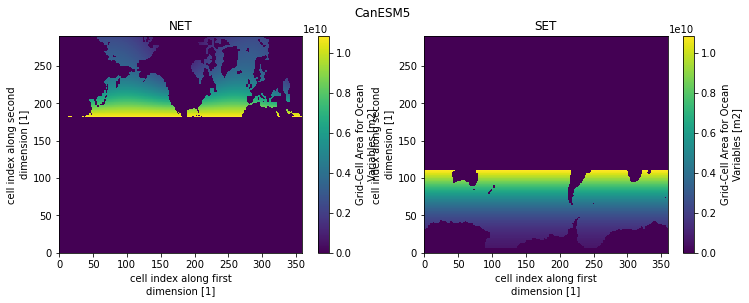

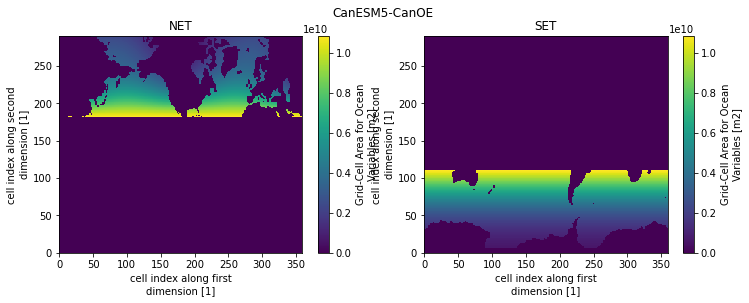

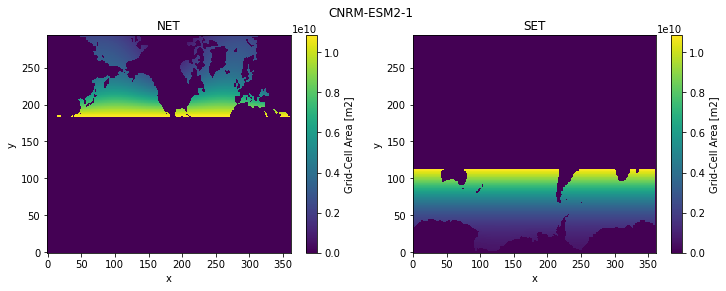

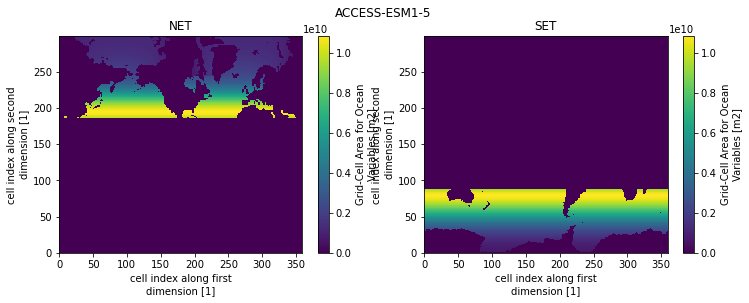

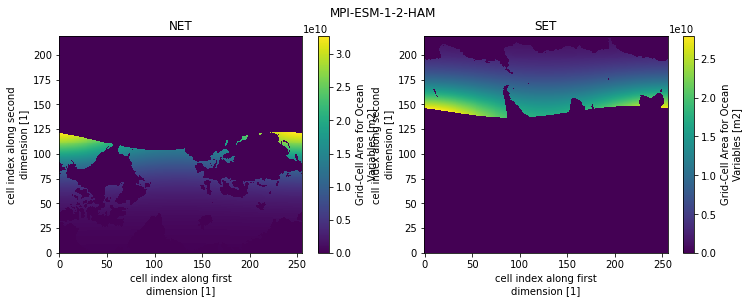

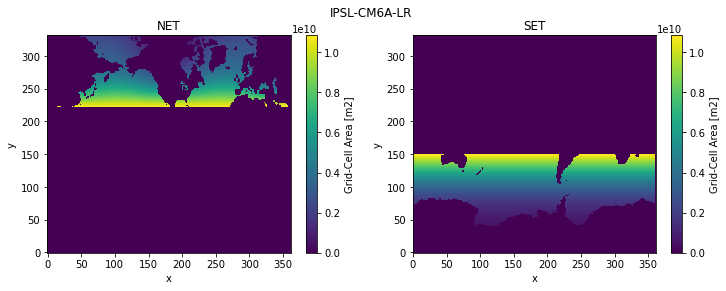

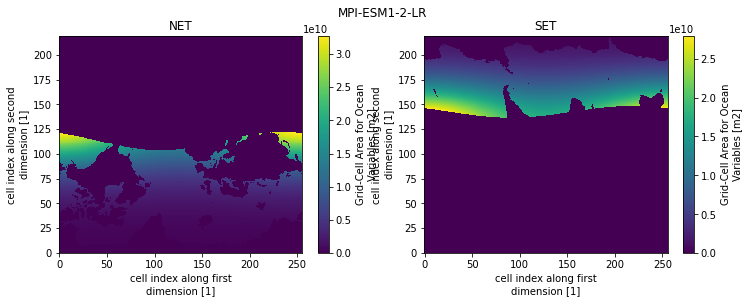

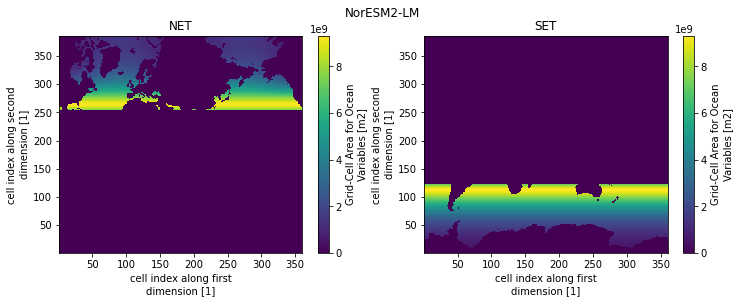

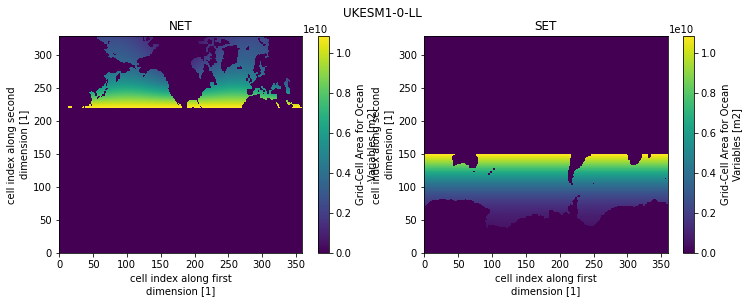

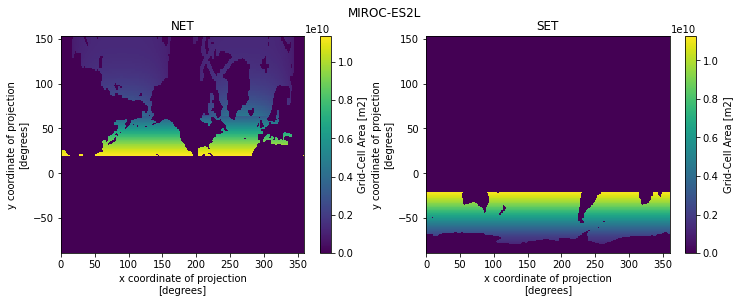

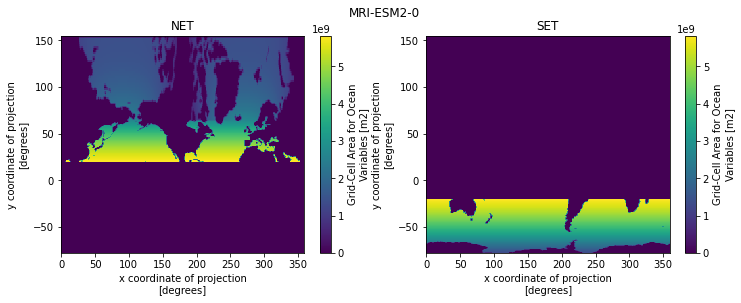

In [70]:
rmask_definition = 'SET_NET' # poleward of 20
#rmask_definition = 'SHL_NHL' # poleward of 45
#rmask_definition = 'global' ### grid-cell area is maxing at 20 degrees in each hemisphere

rmask_dict = {}
for model in models:    
    if model not in dsets_fix:
        continue
    rmask_dict[model] = util.get_rmask_dict(
        dsets_fix[model], 
        mask_definition=rmask_definition, 
        plot=True
    )    

## Assemble monthly-mean climatology

This code takes the following steps:
- Read a dataset for each model
- Compute the regional integral 
- Compute the mean for each month and average across ensemble members
- Concatenate the resulting timeseries along a `source_id` dimension

Note that the code is set up to cache the resulting dataset; it will optionally read this dataset, rather than recreate it, if it exists.

In [71]:
%%time
variable_ids = [
    'intpp', 
    'fgco2', 
    'fgo2', 
    'tos', 
    'sos',
    'hfds',
    #'fbddtdic',
    'epc100',
    'fgn2:tos,sos,hfds',
    'fgo2_thermal:tos,sos,hfds',
    # 'fgapo:fgo2,fgco2,tos,sos,hfds', ## currently crashing on a 'units' error in util.py
]
clobber = False
    
time_slice = slice('2005', '2014') ## for comparison to HIPPO/ORCAS/ATom 2009-2018, pick closest decade
experiment_id = 'historical' 
table_id = 'Omon'
nmax_members = 4

# specify models for each variable that have reverse sign convention
models_flipsign = {v.split(':')[0]: [] for v in variable_ids}
models_flipsign['fgo2'] = ['NorESM2-LM',]

missing_data = util.missing_data_tracker()
if clobber:
    missing_data.clobber()


ds_list = []
source_id_list = []
for source_id in models:    
    if source_id not in rmask_dict:
        continue
        
    ds_list_variable_ids = []
    for variable_name in variable_ids:
        
        if ':' in variable_name:
            search_vars = variable_name.split(':')[-1].split(',')
            variable_id = variable_name.split(':')[0]        
        else:
            search_vars = [variable_name]
            variable_id = variable_name
        
        cache_file = (
            f'data/cache/cmip/cmip6'
            f'.{source_id}'
            f'.{experiment_id}'
            f'.{variable_id}'
            f'.{rmask_definition}'
            f'.monclim_{time_slice.start}-{time_slice.stop}.zarr'
        )
        if os.path.exists(cache_file) and not clobber:
            ds = xr.open_zarr(cache_file)

        else:
            # see if this is missing
            missing_search = missing_data.ismissing(
                source_id=source_id, 
                experiment_id=experiment_id, 
                table_id=table_id,
            )

            if any(missing_search(variable_id=v) for v in search_vars):
                dsi = None
            else:
                dsi = util.open_cmip_dataset(
                    source_id=source_id, 
                    variable_id=search_vars, 
                    experiment_id=experiment_id, 
                    table_id=table_id,
                    time_slice=time_slice, 
                    nmax_members=nmax_members,
                )
            
                # check to ensure all variables are present
                if dsi is None or not all(v in dsi for v in search_vars):
                    print(f'missing data: {source_id}, {experiment_id}')                
                    for v in search_vars:
                        if dsi is None or v not in dsi:
                            print(f'\t{v}')
                            missing_data.set_missing(
                                source_id=source_id, 
                                variable_id=v, 
                                experiment_id=experiment_id, 
                                table_id=table_id,
                            )
                    dsi = None
                
            if dsi is None:
                # generate missing values dataset
                ds = xr.Dataset({
                    variable_id: xr.DataArray(
                        np.ones((len(rmask_dict[source_id]), 12)) * np.nan,
                        dims=('region', 'month'),
                        name=variable_id,
                    )
                })
                
            else:
                # compute derived variables
                if variable_id == 'fgn2':
                    dsi = util.compute_fgn2(dsi)

                elif variable_id == 'fgo2_thermal':
                    dsi = util.compute_fgo2_thermal(dsi)   
                    
                elif variable_id == 'fgapo':
                    dsi = util.compute_fgapo(dsi)

                # compute the regional integrals
                flipsign = True if source_id in models_flipsign[variable_id] else False            
                da = util.compute_regional_integral(
                    ds=dsi, 
                    variable_id=variable_id,
                    rmasks=rmask_dict[source_id],
                    flipsign=flipsign,
                )    

                with xr.set_options(keep_attrs=True):
                    da = da.groupby('time.month').mean().mean('member_id')

                if 'depth' in da.coords:
                    da = da.drop(['depth'])
                
                ds = da.to_dataset().compute()              

                ds.to_zarr(cache_file, mode='w');            
            
        ds_list_variable_ids.append(ds)
    
    if ds_list_variable_ids:
        source_id_list.append(source_id)

    # merge across variables
    if ds_list_variable_ids:
        ds_list.append(xr.merge(ds_list_variable_ids,))

missing_data.persist()        
        
print('final merge')
ds = xr.concat(ds_list, dim=xr.DataArray(source_id_list, dims=('source_id'), name='source_id'))    
ds

final merge
CPU times: user 390 ms, sys: 56.4 ms, total: 446 ms
Wall time: 557 ms


<xarray.Dataset>
Dimensions:       (month: 12, region: 2, source_id: 11)
Coordinates:
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) object 'NET' 'SET'
  * source_id     (source_id) <U15 'CanESM5' 'CanESM5-CanOE' ... 'MRI-ESM2-0'
Data variables:
    intpp         (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgco2         (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgo2          (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    tos           (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    sos           (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    hfds          (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    epc100        (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgn2          (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgo2_thermal  (source_id, region, month) float64 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>

## Make some plots

In [72]:
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

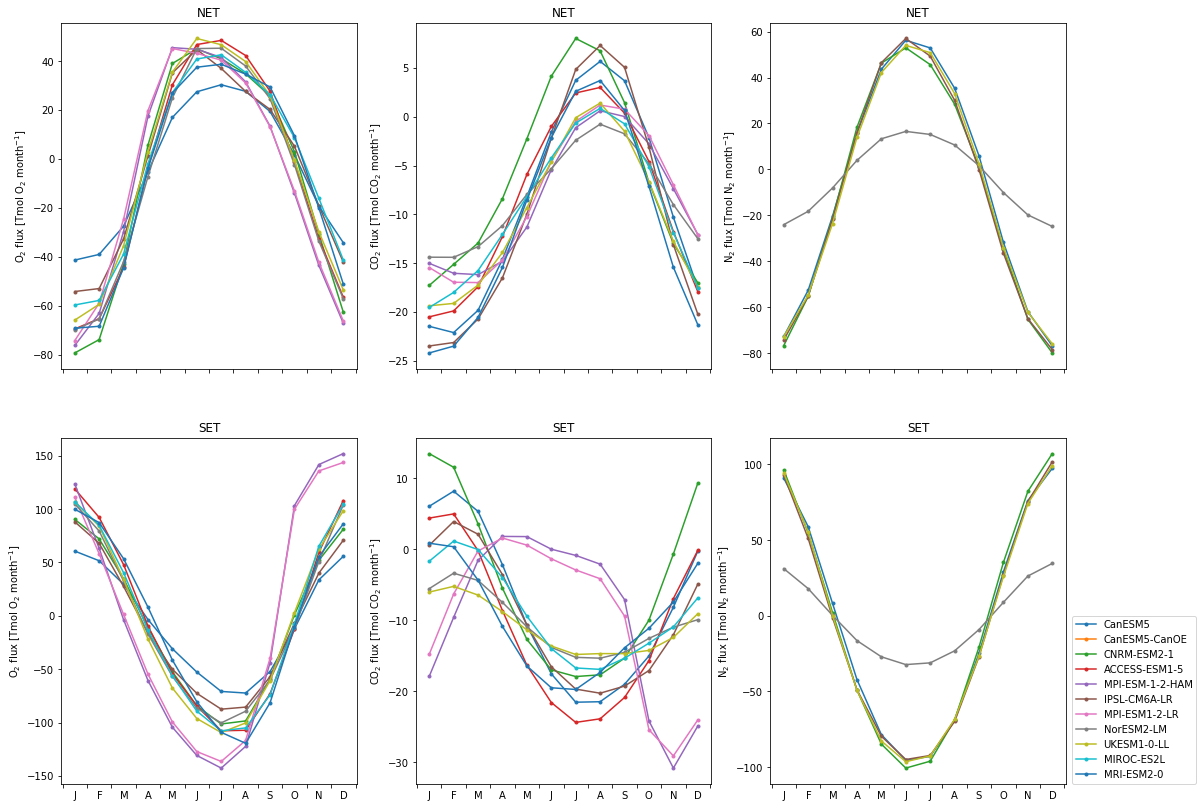

In [73]:
variable_ids = ['fgo2','fgco2','fgn2']  # ,'fgapo']
#variable_ids = ['fgco2','fgo2','fgn2','fgo2_thermal','intpp'] 

#nrows = 2*np.ceil(len(variable_ids)/3).astype(int)
#ncols = np.ceil(len(variable_ids)/nrows).astype(int)
nrows = 2
ncols = len(variable_ids)


fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) # , sharey=True)

for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
    for source_id in ds.source_id.values:
        ax.plot(
            ds.month-0.5, 
            ds[field].sel(source_id=source_id, region=region), 
            marker='.', 
            linestyle='-',
            label=source_id,
        )

    ax.set_xticks(np.arange(13))    
    ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
    ax.set_title(region);
    ax.set_xticklabels([])
    ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
ax.legend(loc=(1.02, 0));

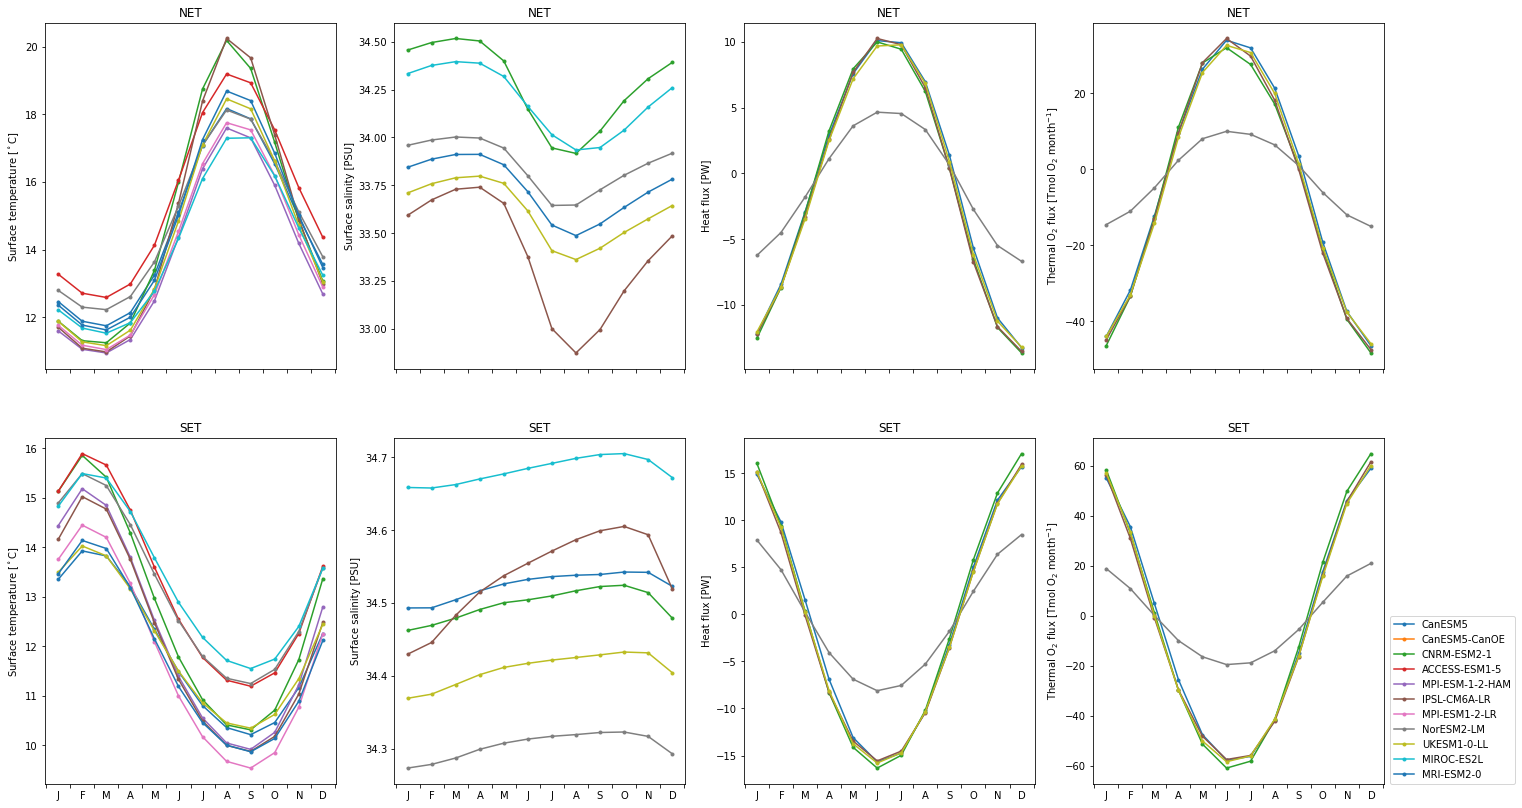

In [74]:
variable_ids = [ 'tos', 'sos', 'hfds','fgo2_thermal' ]

nrows = 2
ncols = len(variable_ids)

fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) #, sharey=True)

for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
    for source_id in ds.source_id.values:
        ax.plot(
            ds.month-0.5, 
            ds[field].sel(source_id=source_id, region=region), 
            marker='.', 
            linestyle='-',
            label=source_id,
        )

    ax.set_xticks(np.arange(13))    
    ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
    ax.set_title(region);
    ax.set_xticklabels([])
    ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
ax.legend(loc=(1.02, 0));

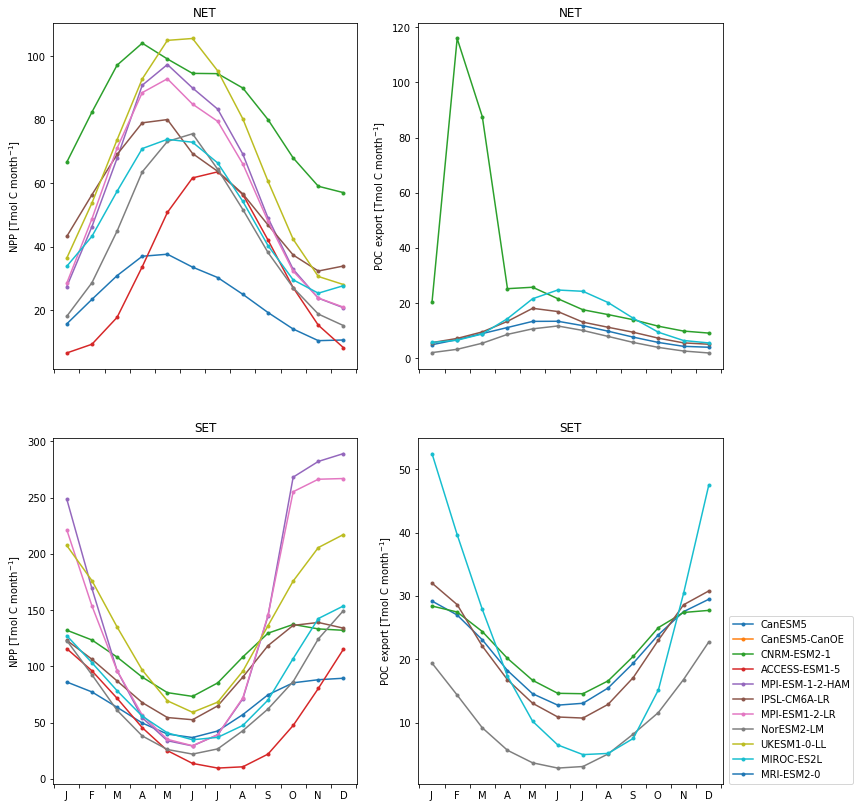

In [75]:
variable_ids = [ 'intpp', 'epc100'] # ,'fbddtdic']

nrows = 2
ncols = len(variable_ids)

fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) #, sharey=True)

for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
    for source_id in ds.source_id.values:
        ax.plot(
            ds.month-0.5, 
            ds[field].sel(source_id=source_id, region=region), 
            marker='.', 
            linestyle='-',
            label=source_id,
        )

    ax.set_xticks(np.arange(13))    
    ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
    ax.set_title(region);
    ax.set_xticklabels([])
    ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
ax.legend(loc=(1.02, 0));

In [76]:
ds.source_id.values

array(['CanESM5', 'CanESM5-CanOE', 'CNRM-ESM2-1', 'ACCESS-ESM1-5',
       'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'NorESM2-LM',
       'UKESM1-0-LL', 'MIROC-ES2L', 'MRI-ESM2-0'], dtype='<U15')

In [187]:
# calculate SNO (work in progress)

# defining SNO here as the seasonal component of the O2 (or APO for SNOapo) flux
# specifically the integral of positive flux values after subtracting the annual mean
# (or the amplitude of the time-integrated flux cycle)
# this is to match the observed APO cycle in the atmosphere which has an arbitrary mean (is agnostic to annual mean fluxes)

# first remove the annual mean
#for source_id in ds.source_id.values:
source_id='CanESM5'
#    for region in ds.region.values:        
region='SET'

ds['fgo2seas'] = ds['fgo2'].sel(source_id=source_id, region=region)-ds['fgo2'].sel(source_id=source_id, region=region).mean()

# then sum positive values
ds['sno']=sum(x for x in ds['fgo2seas'] if x > 0)
ds['sno'].values # 259.56


ValueError: different number of dimensions on data and dims: 0 vs 2

In [178]:
tmp=
ds['sno'].expand_dims(dim='source_id')

<xarray.DataArray 'sno' (source_id: 1)>
dask.array<broadcast_to, shape=(1,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: source_id

In [172]:
# alternately calculate time integral first
ds['fgo2cum'] = ds['fgo2'].sel(source_id=source_id, region=region).cumsum()
ds['fgo2cum'] = ds['fgo2seas'].cumsum()
#ds['fgo2cum'].values
#ds['fgo2cumseas'] = ds['fgo2cum']-ds['fgo2cum'].mean()
ds['sno'] = ds['fgo2cum'].max() - ds['fgo2cum'].min()
ds['sno'].values # 259.56

array(259.5581913)

In [173]:
# does it matter if you interpolate to daily resolution first? only slightly
tmp=ds['fgo2seas']
tmp2=np.interp(np.arange(0,366)/365*12,tmp.month-0.5,tmp,period=12)
sum(x for x in tmp2 if x > 0)*12/365 # 257.90

257.89942612370066

In [177]:
### now just need to figure out how to loop and combine into a dataarray with same dimensions

In [16]:
# list all models in catalog
cat.df.source_id.unique()

array(['BCC-ESM1', 'CNRM-ESM2-1', 'MPI-ESM-1-2-HAM', 'MIROC6',
       'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'NorESM2-LM', 'UKESM1-0-LL',
       'GFDL-ESM4', 'BCC-CSM2-MR', 'CanESM5', 'GISS-E2-1-G', 'TaiESM1',
       'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAMS-CSM1-0', 'FGOALS-f3-L',
       'FGOALS-g3', 'IITM-ESM', 'CanESM5-CanOE', 'CMCC-CM2-HR4',
       'CMCC-CM2-SR5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'ACCESS-CM2',
       'ACCESS-ESM1-5', 'E3SM-1-0', 'EC-Earth3-AerChem', 'EC-Earth3-CC',
       'EC-Earth3-LR', 'EC-Earth3-Veg-LR', 'EC-Earth3-Veg', 'EC-Earth3',
       'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'KIOST-ESM', 'MIROC-ES2L', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'GISS-E2-1-G-CC', 'GISS-E2-1-H',
       'CESM2-FV2', 'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM1-F',
       'NorESM2-MM', 'KACE-1-0-G', 'GFDL-AM4', 'GFDL-CM4', 'NESM3',
       'SAM0-UNICON', 'CIESM', 'MCM-UA-1-0', 'CESM1-1-CAM5-CMIP5',
       'FGOALS-f3-H', 'CMCC-CM2-

In [48]:
# list all models that include historical Omon fgo2
# cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Oyr', variable_id='o2', grid_label='gn')
tmp = cat.search(experiment_id='historical', table_id='Omon', grid_label='gn', variable_id='fgo2')
tmp.df.source_id.unique()

array(['BCC-CSM2-MR', 'BCC-ESM1', 'CanESM5', 'CNRM-ESM2-1',
       'ACCESS-ESM1-5', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MIROC-ES2L',
       'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0',
       'GISS-E2-1-G-CC', 'GISS-E2-1-G', 'CESM2-FV2', 'CESM2-WACCM-FV2',
       'CESM2-WACCM', 'CESM2', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM'],
      dtype=object)